In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from timeit import timeit
from IPython.display import display
import pandas as pd
import numpy as np
from sklearn.metrics import cohen_kappa_score, f1_score
from sklearn.model_selection import cross_val_score, train_test_split
from joblib import dump, load
from imblearn.under_sampling import RandomUnderSampler

In [2]:
from compiledataset import load_dataset, compile_dataset

PATH = "/home/hampus/miun/master_thesis/Datasets"

datasets = {}

# dataset: pd.DataFrame = load_dataset(PATH + "/ORNL", "data_a.csv")
# dataset["remarks"] = "No DLC available"
# datasets["ROAD"] = dataset.to_dict("records")

dataset: pd.DataFrame = load_dataset(PATH + "/Survival", "data.csv", "Malfunction_dataset_SONATA")
dataset["remarks"] = "-"
datasets["Survival"] = dataset.to_dict("records")

# dataset: pd.DataFrame = load_dataset(PATH + "/Hisingen", "data.csv")
# dataset["remarks"] = "-"
# datasets["Hisingen"] = dataset.to_dict("records")


df = compile_dataset(datasets)
# df.to_csv("../../../Datasets/Survival/data/test_data.csv", index=False)

df.drop(columns=["data", "data_dec", "ID", "DLC", "t"], inplace=True, errors="ignore")
df.drop(columns=["d0", "d1", "d2", "d3", "d4", "d5", "d6", "d7"], inplace=True, errors="ignore")

dataset = None # Release memory, as it isn't used for now
datasets = None

display(df)

,dcs,dcs_ID,dt,dt_ID,dt_data,dt_d0,dt_d1,dt_d2,dt_d3,dt_d4,dt_d5,dt_d6,dt_d7,name,class,dataset,type,Label
0,0.359751,0.001825,0.000454,0.010020,0.011058,0.009955,0.011058,0.000813,0.001128,0.001077,0.014583,0.000731,0.000813,Malfunction_dataset_SONATA,Sonata,Survival,fabr,0
1,0.437500,0.086186,0.000216,0.010020,0.810513,0.019615,0.012661,0.022553,0.010020,0.000216,0.031360,0.419730,0.149824,Malfunction_dataset_SONATA,Sonata,Survival,fabr,0
2,0.500000,0.023501,0.000233,0.010020,0.062487,0.037761,0.001244,0.016652,0.010020,0.009849,0.009431,0.010020,0.000449,Malfunction_dataset_SONATA,Sonata,Survival,fabr,0
3,0.421875,0.007019,0.000236,0.010191,0.041340,0.020174,0.010495,0.010191,0.010191,0.010191,0.007932,0.000685,0.006672,Malfunction_dataset_SONATA,Sonata,Survival,fabr,0
4,0.359375,0.066017,0.000237,0.010041,0.205859,0.004676,0.004630,0.114321,0.010041,0.013307,0.001195,0.000237,0.136140,Malfunction_dataset_SONATA,Sonata,Survival,fabr,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132646,0.500000,0.000000,0.000239,0.010094,0.010094,0.010094,0.010094,0.002523,0.003694,0.003694,0.010094,0.000239,0.002523,Malfunction_dataset_SONATA,Sonata,Survival,fabr,0
132647,0.437500,0.046875,0.000235,0.010094,12.029791,0.010094,0.000474,0.010094,0.010094,0.000235,0.010094,0.010094,0.327832,Malfunction_dataset_SONATA,Sonata,Survival,fabr,0
132648,0.484375,0.015625,0.000234,0.010092,0.039899,0.039899,0.004163,0.010092,0.010092,0.010092,0.010092,0.010092,0.000469,Malfunction_dataset_SONATA,Sonata,Survival,fabr,0
132649,0.453125,0.000000,0.000232,0.010092,0.010092,0.010092,0.010092,0.010092,0.010092,0.010092,0.010092,0.000701,0.006558,Malfunction_dataset_SONATA,Sonata,Survival,fabr,0


In [3]:
# from load_signal_road import load_signal_road
# df = load_signal_road()
# df.drop(columns=["ID", "t"], inplace=True)
# df.fillna(-100000, inplace=True)
# display(df)

# X_train = df.drop(columns=["Label"])
# y_train = df["Label"]
# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=0, shuffle=True, stratify=y_train)

In [4]:
# rus = RandomUnderSampler(random_state=0)
# X_train, y_train = rus.fit_resample(X_train, y_train)
# X_test, y_test = rus.fit_resample(X_test, y_test)
# bintr = np.bincount(y_train)
# binte = np.bincount(y_test)
# print(f"Labels\t\tTraining\tTesting\nNormal\t\t{bintr[0]}\t\t{binte[0]}\nAttack\t\t{bintr[1]}\t\t{binte[1]}")

In [5]:
# from sklearn.ensemble import RandomForestClassifier

# clf = RandomForestClassifier(n_estimators=20, random_state=0, max_leaf_nodes=300, max_features="log2", warm_start=True)
# clf.fit(X_train, y_train)

In [6]:
# scores = cross_val_score(clf, X_train, y_train, scoring='f1', cv=10, n_jobs=-1)
# print("Training F1: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std()))

# pred = clf.predict(X_test)

# f1_scores = f1_score(y_test, pred, average='weighted')
# print("Testing F1:  %0.4f(+/- %0.4f)" % (f1_scores.mean(), f1_scores.std()))

# kappa_scores = cohen_kappa_score(y_test, pred)
# print("Kappa score:  %0.4f(+/- %0.4f)" % (kappa_scores.mean(), kappa_scores.std()))

In [7]:
# from plot_tools import plot_confusion_matrix

# pred_train = clf.predict(X_train)

# plot_confusion_matrix(y_train, pred_train, "Survival, All Attacks, RF\nrate\n(# of instances)")

In [8]:
# import shap
# exp = shap.TreeExplainer(clf, data=X_train, model_output="probability")

# from shap_tools import *
# shap_all = get_explanation(exp, X_train, 600)

# plot_beeswarm(shap_all)

Test Above ^^^

In [9]:
df = df.loc[df["type"] != "masq"]
# df = df.loc[(df["type"] == "fuzz") | (df["type"] == "none")]

In [10]:
# col = "dcs"
# v_r         = df.loc[(df["Label"] == 0) & (df["dataset"] == "ROAD"), col]
# v_sonata    = df.loc[(df["Label"] == 0) & (df["dataset"] == "Survival") & (df["class"] == "Sonata"), col]
# v_soul      = df.loc[(df["Label"] == 0) & (df["dataset"] == "Survival") & (df["class"] == "Soul"), col]
# v_spark     = df.loc[(df["Label"] == 0) & (df["dataset"] == "Survival") & (df["class"] == "Spark"), col]

# print(v_r.mean(), v_r.std())
# print(v_sonata.mean(), v_sonata.std())
# print(v_soul.mean(), v_soul.std())
# print(v_spark.mean(), v_spark.std())

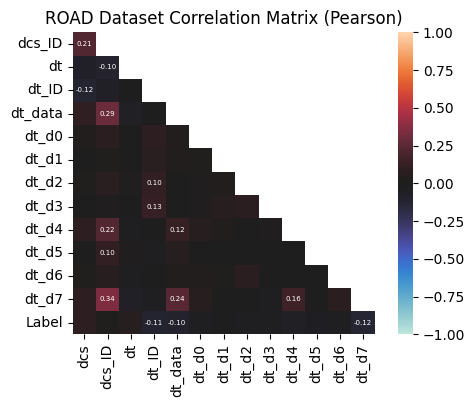

In [11]:
from plot_tools import plot_correlation_matrix

plot_correlation_matrix(df.drop(columns=["dataset", "type", "name", "class" "ID", "DLC", "t"], errors="ignore"))

In [12]:
# from sklearn.preprocessing import StandardScaler, RobustScaler

# feature_columns= list(set(df.columns.to_list()).difference(["name", "class", "dataset", "type", "Label"]))

# for col in feature_columns:
#     scaler = StandardScaler().fit(df.loc[df["Label"] == 0, df.columns == col])
#     df.loc[:, df.columns == col] = scaler.transform(df.loc[:, df.columns == col])

# display(df)

In [13]:
# Stratify on the sub-dataset
X_train = df.drop(columns="Label")
y_train = df["Label"]

df = None # Release memory

# Split dataset into training and test data, stratify by the type of attack
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=0, shuffle=True, stratify=X_train["name"])

In [14]:
# X_train = df.loc[df["type"] != "normal"]
# y_train = X_train["Label"]
# X_train = X_train.drop(columns="Label")

# X_test = df.loc[df["type"] == "normal"]
# y_test = X_test["Label"]
# X_test = X_test.drop(columns="Label")

In [15]:
rus = RandomUnderSampler(random_state=0)
X_train, y_train = rus.fit_resample(X_train, y_train)
X_test, y_test = rus.fit_resample(X_test, y_test)
bintr = np.bincount(y_train)
binte = np.bincount(y_test)
print(f"Labels\t\tTraining\tTesting\nNormal\t\t{bintr[0]}\t\t{binte[0]}\nAttack\t\t{bintr[1]}\t\t{binte[1]}")

Labels		Training	Testing
Normal		11157		4817
Attack		11157		4817


In [16]:
# train_index = X_train.loc[X_train["dataset"] == "Survival"].index
# test_index = X_test.loc[X_test["dataset"] == "ROAD"].index
# train_index = X_train.loc[(X_train["dataset"] == "Survival") & (X_train["name"] == "Fuzzy_dataset_SONATA")].index
# test_index = X_test.loc[(X_test["dataset"] == "ROAD") & (X_test["name"] == "fuzzing_attack_1")].index

# X_train = X_train.loc[train_index]
# y_train = y_train.loc[train_index]

# X_test = X_test.loc[test_index]
# y_test = y_test.loc[test_index]

In [17]:
name_train = X_train["name"]
# name_test = X_test["name"]
X_train.drop(columns=["type", "dataset", "name", "class"], inplace=True)
X_test.drop(columns=["type", "dataset", "name", "class"], inplace=True)

In [18]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=20, random_state=0, max_leaf_nodes=300, max_features="log2", warm_start=True)
clf.fit(X_train, y_train)

RandomForestClassifier(max_features='log2', max_leaf_nodes=300, n_estimators=20,
                       random_state=0, warm_start=True)

In [19]:
# pred_train = clf.predict(X_train)
# clf.set_params(n_estimators=(20+13)) # Add another tree for the FN and FPs
# clf.fit(X_train.loc[y_train != pred_train], y_train.loc[y_train != pred_train])

In [20]:
f1_scores_train = cross_val_score(clf, X_train, y_train, scoring='f1', cv=10, n_jobs=-1)
print("Training F1: %0.4f (+/- %0.4f)" % (f1_scores_train.mean(), f1_scores_train.std()))

pred = clf.predict(X_test)

# f1_scores_test = f1_score(y_test, pred, average='weighted')
f1_scores_test = cross_val_score(clf, X_test, y_test, scoring='f1', cv=10, n_jobs=-1)
print("Testing F1:  %0.4f(+/- %0.4f)" % (f1_scores_test.mean(), f1_scores_test.std()))

kappa_scores = cohen_kappa_score(y_test, pred)
# kappa_scores = cross_val_score(clf, X_test, y_test, scoring='kappa', cv=10, n_jobs=-1)
print("Kappa score:  %0.4f(+/- %0.4f)" % (kappa_scores.mean(), kappa_scores.std()))

Training F1: 0.9994 (+/- 0.0005)
Testing F1:  0.9992(+/- 0.0008)
Kappa score:  0.9994(+/- 0.0000)


Plot train then test data predictions

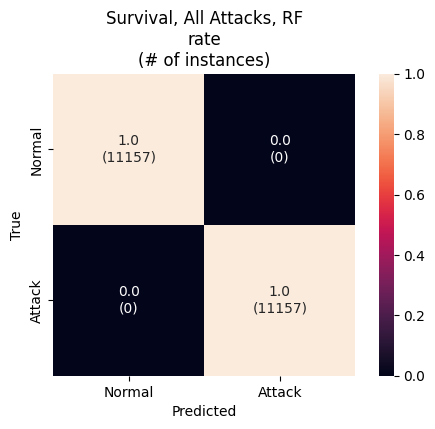

In [21]:
from plot_tools import plot_confusion_matrix

pred_train = clf.predict(X_train)

plot_confusion_matrix(y_train, pred_train, "Survival, All Attacks, RF\nrate\n(# of instances)")

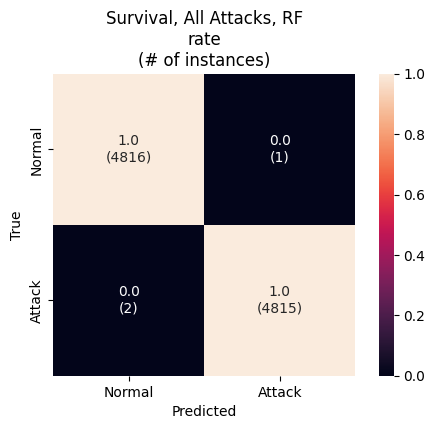

In [22]:
plot_confusion_matrix(y_test, pred, "Survival, All Attacks, RF\nrate\n(# of instances)")

In [23]:
import shap

exp = shap.TreeExplainer(clf, data=X_train, model_output="probability")

In [24]:
from shap_tools import *


# Make sure that the ingested SHAP model (a TreeEnsemble object) makes the
# same predictions as the original model
assert np.abs(exp.model.predict(X_train) - clf.predict_proba(X_train)).max() < 1e-4

shap_all = get_explanation(exp, X_train, 600)

# # Make sure the SHAP values sum up to the model output (this is the local accuracy property)
# assert np.abs((shap_all.base_values + shap_all.values).sum(1) - clf.predict_proba(X_train)).max() < 1e-4

# print(len(X_train.loc[y_train != pred]))
# print(len(X_train.loc[y_train == pred]))
# shap_false = get_explanation(exp, X_train.loc[y_train != pred])
# shap_FP = get_explanation(exp, X_train.loc[(y_train != pred) & (pred == 1)])
# shap_FN = get_explanation(exp, X_train.loc[(y_train != pred) & (pred == 0)])
# shap_true = get_explanation(exp, X_train.loc[y_train == pred])
# shap_TP = get_explanation(exp, X_train.loc[(y_train == pred) & (pred == 1)])
# shap_TN = get_explanation(exp, X_train.loc[(y_train == pred) & (pred == 0)])

# shap_TP_fuzz = get_explanation(exp, X_test.loc[(y_train == pred) & (pred == 1) & (name_test == "Fuzzy_dataset_SONATA")])

In [25]:
display(shap_all[:1,"dt_ID"])

.values =
array([0.17037501])

.base_values =
array([0.55])

.data =
array([0.00239491])

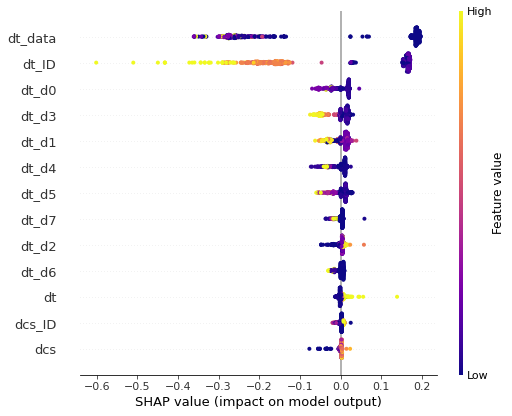

In [26]:
plot_beeswarm(shap_all)

<AxesSubplot:>

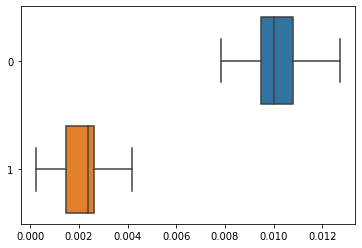

In [70]:
import seaborn as sns

dt_ID_attack = shap_all.data[pred_train[X_train.sample(600, random_state=0).index] == 1][:,3]
dt_ID_normal = shap_all.data[pred_train[X_train.sample(600, random_state=0).index] == 0][:,3]

dt_data_attack = shap_all.data[pred_train[X_train.sample(600, random_state=0).index] == 1][:,4]
dt_data_normal = shap_all.data[pred_train[X_train.sample(600, random_state=0).index] == 0][:,4]

print()
print()

print()
print()

sns.boxplot(data=[dt_ID_normal, dt_ID_attack], orient="h", showfliers=False)

In [27]:
# shap_TP_fuzz = get_explanation(exp, X_train.loc[(y_train == pred_train) & (pred_train == 1) & (name_train == "Fuzzy_dataset_SONATA")])
# plot_waterfall(shap_TP_fuzz, 0)

In [56]:
plot_force(shap_all[65])

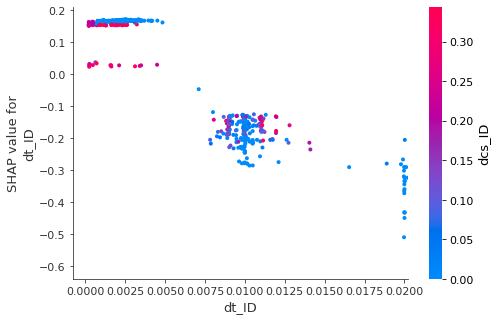

In [31]:
plot_dependence(shap_all, "dt_ID", "dcs_ID", xmax="percentile(99)")

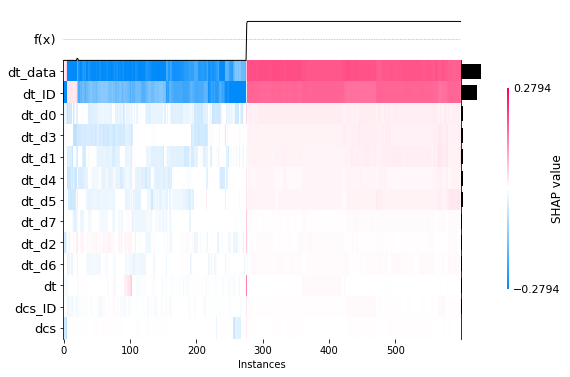

In [32]:
plot_heatmap(shap_all)

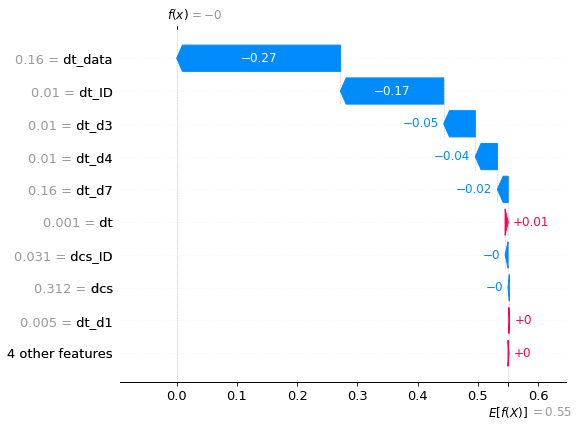

In [33]:
# display(pd.Series(shap_all.data[4], index=shap_all.feature_names))
plot_waterfall(shap_all, 4)

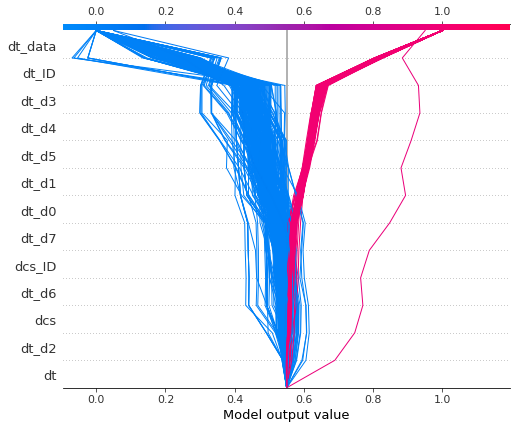

In [42]:
r = shap.decision_plot(shap_all.base_values[1],
    shap_all.values,
    pd.DataFrame(shap_all.data, columns=shap_all.feature_names),
    feature_order='hclust',
    return_objects=True
)

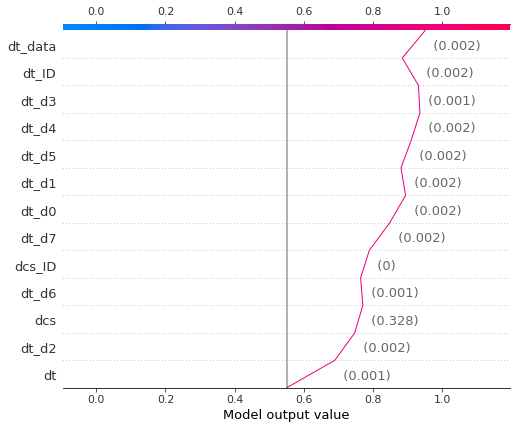

In [48]:
idx = np.argpartition(shap_all.values[:, pd.DataFrame(shap_all.data, columns=shap_all.feature_names).columns.get_loc('dt')], -2)[-1]
shap.decision_plot(shap_all.base_values[1],
    shap_all.values[idx],
    pd.DataFrame(shap_all.data, columns=shap_all.feature_names),
    feature_order=r.feature_idx,
    xlim=r.xlim
)

In [60]:
plot_force(shap_all[0])

In [160]:
# feature1 = "dcs_ID"
# idx = shap_all.feature_names.index(feature1)
# shap_sums = np.sum(shap_all.values, axis=1)
# rule1 = X_train.sample(600, random_state=0)[(shap_sums > 0) & (shap_all.values[:,idx] > 0)][feature1].min()
# rule1

In [161]:
# feature2 = "dt_ID"
# idx = shap_all.feature_names.index(feature1)
# shap_sums = np.sum(shap_all.values, axis=1)
# rule2 = X_train.sample(600, random_state=0)[(shap_sums > 0) & (shap_all.values[:,idx] < 0)][feature1].max()
# rule2 = 1

In [162]:
# def rule_predictor(X: pd.DataFrame, y: pd.DataFrame):
#     mask = (X[feature1] >= rule1) | (X[feature2] >= rule2)
#     pred_out = y.copy() * 0
#     pred_out.loc[mask] = 1
#     # for i, row in X.iterrows():
#     return pred_out

# preddy = rule_predictor(X_test, y_test)

# plot_confusion_matrix(y_test, preddy, "Rule classification")

# zeros = np.bincount(y_test.loc[mask])[0]
# ones = np.bincount(y_test.loc[mask])[1]
# # print(zeros)
# print(1 - zeros/ones)

In [163]:
# from sklearn.metrics import confusion_matrix
# pred_train = clf.predict(X_train)
# cm = confusion_matrix(y_train, pred_train)

# result = [[cm[0][1]], [cm[1][0]]]

# for i in range(1, 31):
#     clf.set_params(n_estimators=(20+i)) # Add another tree for the FN and FPs
#     clf.fit(X_train.loc[y_train != pred_train], y_train.loc[y_train != pred_train]) # 1 for FP, 0 for FN
#     pred_train = clf.predict(X_train)
#     cm = confusion_matrix(y_train, pred_train)
#     result[0].append(cm[0][1])
#     result[1].append(cm[1][0])

# print(result[0])
# print(result[1])

In [164]:
# plt.plot(result[0], label="FP")
# plt.plot(result[1], label="FN")
# plt.title("Change in FP and FN predictions\nwith more trees trained on FP and FN instances")
# plt.xlabel("Number of additional trees (originally 20)")
# plt.ylabel("Number of instances")
# plt.legend()
# plt.show